✅ Connexion réussie au moteur SQLAlchemy.
✅ Données récupérées avec succès !

🔹 Random Forest (best params)
Matrice de confusion :


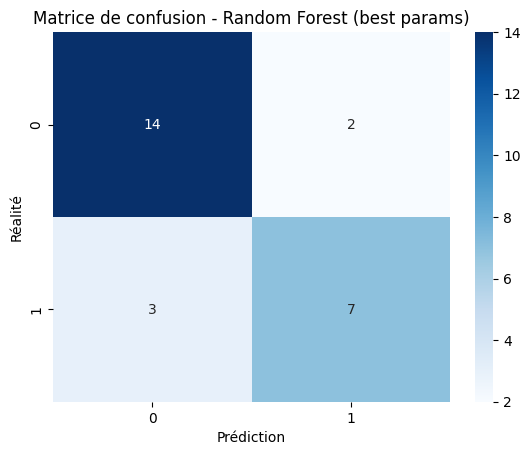

Rapport de classification :
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.78      0.70      0.74        10

    accuracy                           0.81        26
   macro avg       0.80      0.79      0.79        26
weighted avg       0.81      0.81      0.81        26


🔹 KNN
Matrice de confusion :


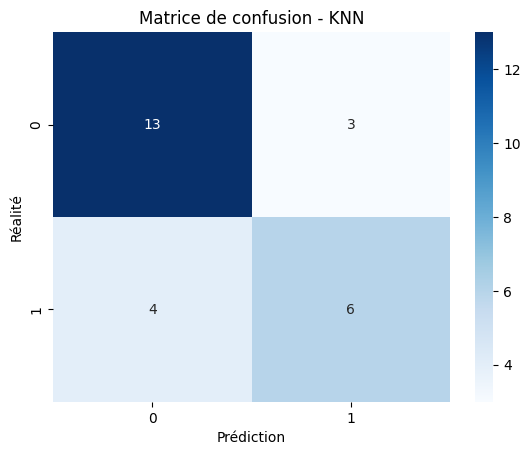

Rapport de classification :
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16
           1       0.67      0.60      0.63        10

    accuracy                           0.73        26
   macro avg       0.72      0.71      0.71        26
weighted avg       0.73      0.73      0.73        26


🔹 SVM
Matrice de confusion :


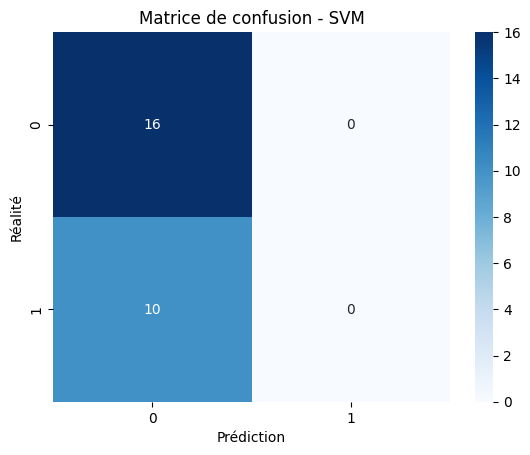

Rapport de classification :
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        16
           1       0.00      0.00      0.00        10

    accuracy                           0.62        26
   macro avg       0.31      0.50      0.38        26
weighted avg       0.38      0.62      0.47        26


🔹 Decision Tree
Matrice de confusion :


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

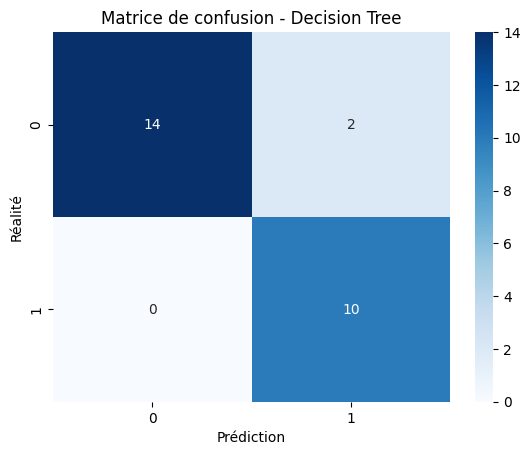

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.83      1.00      0.91        10

    accuracy                           0.92        26
   macro avg       0.92      0.94      0.92        26
weighted avg       0.94      0.92      0.92        26


✅ Résumé des performances :
                        Modèle  Accuracy
3                Decision Tree  0.923077
0  Random Forest (best params)  0.807692
1                          KNN  0.730769
2                          SVM  0.615385

👉 Le modèle à choisir est : **Decision Tree** avec une accuracy de **0.92**


['decision_tree_model.pkl']

In [2]:

# 1️⃣ Importation
import joblib

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 2️⃣ Connexion à PostgreSQL
USERNAME = os.getenv("POSTGRES_USER", "postgres")
PASSWORD = os.getenv("POSTGRES_PASSWORD", "123456789")
HOST = os.getenv("POSTGRES_HOST", "localhost")
PORT = os.getenv("POSTGRES_PORT", "5432")
DATABASE = os.getenv("POSTGRES_DB", "DBM")

DATABASE_URL = f"postgresql://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"

try:
    engine = create_engine(DATABASE_URL)
    with engine.connect() as connection:
        print("✅ Connexion réussie au moteur SQLAlchemy.")

    query = '''
    SELECT 
        f."ReadmissionNbr",
        f."Admissionn_Count",
        f."ICU_Admission",
        f."death",
        p."Gender",
        p."Bmi",
        p."Weight",
        p."Height",
        p."date_of_birth"
    FROM public."FACT_CLINICAL_OUTCOMES" f
    INNER JOIN public."Dim_Patient" p ON f."FK_Patient" = p."PK_Patient";
'''

    df = pd.read_sql(query, engine)
    print("✅ Données récupérées avec succès !")

    # 3️⃣ Prétraitement
    df["readmitted"] = (df["ReadmissionNbr"] > 0).astype(int)
    df = df.drop(columns=["ReadmissionNbr", "death", "date_of_birth"]).dropna()

    for col in ["Bmi", "Weight", "Height"]:
        df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

    df["Gender"] = LabelEncoder().fit_transform(df["Gender"])

    X = df.drop("readmitted", axis=1)
    y = df["readmitted"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 4️⃣ Définir les modèles
    models = {
        "Random Forest (best params)": GridSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_grid={
                'n_estimators': [100],
                'max_depth': [5],
                'min_samples_split': [2],
                'min_samples_leaf': [1],
                'bootstrap': [True]
            },
            cv=5,
            n_jobs=-1,
            verbose=0
        ),
        "KNN": KNeighborsClassifier(),
        "SVM": SVC(),
        "Decision Tree": DecisionTreeClassifier()
    }

    # 5️⃣ Entraînement, prédiction et évaluation
    performances = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        best_model = model.best_estimator_ if isinstance(model, GridSearchCV) else model
        y_pred = best_model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        performances.append([name, acc])

        print(f"\n🔹 {name}")
        print("Matrice de confusion :")
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
        plt.title(f"Matrice de confusion - {name}")
        plt.xlabel("Prédiction")
        plt.ylabel("Réalité")
        plt.show()

        print("Rapport de classification :")
        print(classification_report(y_test, y_pred))

    # 6️⃣ Résumé
    summary = pd.DataFrame(performances, columns=["Modèle", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
    print("\n✅ Résumé des performances :")
    print(summary)

    best_model = summary.iloc[0]
    print(f"\n👉 Le modèle à choisir est : **{best_model['Modèle']}** avec une accuracy de **{best_model['Accuracy']:.2f}**")

except Exception as e:
    print(f"❌ Erreur lors de l'exécution : {e }")
    import joblib

# Sauvegarde du meilleur modèle : Decision Tree
best_model = models["Decision Tree"]
best_model.fit(X_train, y_train)
joblib.dump(best_model, "decision_tree_model.pkl")




